In [1]:
#importation de bibliothèques
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import nltk
nltk.download('stopwords')
nltk.download('punkt')    # Pour la tokenisation des mots
nltk.download('punkt_tab')
nltk.download('wordnet')   # Pour la lemmatisation
import spacy
import gensim
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


1. Exploration des données :

In [3]:
#Chargement des données
df  = pd.read_csv('/content/train.csv.zip')
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
#Afficher les colonnes du df
df.columns

Index(['id', 'label', 'tweet'], dtype='object')

In [5]:
#Obtenir des information sur le df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


**Analyser** **la distribution des Classes**

label
0    29720
1     2242
Name: count, dtype: int64


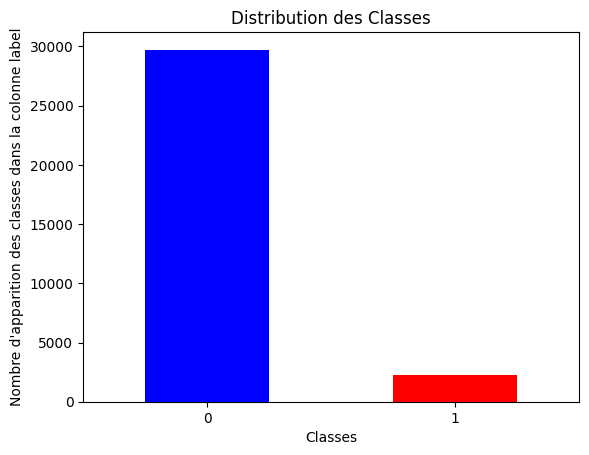

In [6]:
# Compter les occurrences de chaque classe
class_counts = df['label'].value_counts() #0 pour non haineux et 1 pour discours haineux.
print(class_counts)

# Visualiser la distribution
class_counts.plot(kind='bar', color=['blue', 'red'])
plt.title("Distribution des Classes")
plt.xlabel("Classes")
plt.ylabel("Nombre d'apparition des classes dans la colonne label")
plt.xticks(rotation=0)
plt.show()


**Analyser les caractéristiques textuelles du dataset**

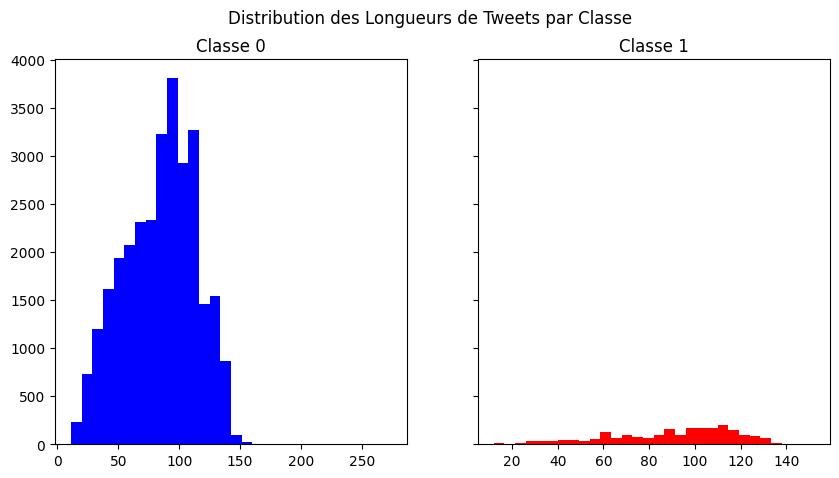

In [7]:
# Création des histogrammes pour chaque classe avec des couleurs spécifiques
classes = df['label'].unique()  # Identifier les classes uniques ([0, 1])
colors = ['blue', 'red']  # Définir les couleurs

# Calculer la longueur moyenne des tweets et l'ajouter au df
df['tweet_length_char'] = df['tweet'].apply(len)

# Créer un sous-graphe par classe
fig, axes = plt.subplots(1, len(classes), figsize=(10, 5), sharey=True)  # Un graphique par classe

for i, cls in enumerate(classes):
  # Filtrer les tweets par classe
    subset = df[df['label'] == cls]
    axes[i].hist(subset['tweet_length_char'], bins=30, color=colors[i])  # Histogramme pour la classe
    axes[i].set_title(f"Classe {cls}")  # Ajouter un titre à chaque sous-graphe

# Titre général et affichage
plt.suptitle("Distribution des Longueurs de Tweets par Classe")
plt.show()

In [8]:
# Calculer la fréquence des mots
from sklearn.feature_extraction.text import CountVectorizer

# Vectorisation pour trouver les mots les plus fréquents
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(df['tweet'])

# Afficher les mots les plus fréquents
word_freq = pd.DataFrame({
    'word': vectorizer.get_feature_names_out(),
    'frequency': X.toarray().sum(axis=0)
}).sort_values(by='frequency', ascending=False)
print(word_freq)


        word  frequency
18      user      17577
10      love       2749
2        day       2311
0        amp       1776
6      happy       1686
7       just       1365
16      time       1136
8       life       1131
17     today       1079
9       like       1050
11       new        997
15  thankful        946
13  positive        931
12    people        874
5       good        867
1     bihday        845
14     smile        712
3        don        665
19      want        649
4     father        635


In [9]:
#Analyser les hashtags les plus utilisés

# Extraire les hashtags
df['hashtags'] = df['tweet'].apply(lambda x: re.findall(r"#(\w+)", x))

# Décompte des hashtags
hashtags = df['hashtags'].explode().value_counts()
print(hashtags.head(10))


hashtags
love           1542
positive        874
healthy         571
smile           548
thankful        491
fun             434
life            406
summer          367
model           365
affirmation     363
Name: count, dtype: int64


2. Prétraitement des données :


**Nettoyage des tweets**

In [10]:
#Définir une fonction appelée "clean_tweet"

def clean_tweet(tweet):

    # Supprimer les URLs
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)

    # Supprimer les mentions (@)
    tweet = re.sub(r"@\w+", '', tweet)

    # Supprimer les caractères spéciaux et la ponctuation
    tweet = re.sub(r"[^a-zA-Z0-9\s]", '', tweet)

    # Convertir en minuscules
    tweet = tweet.lower()

    # Supprimer les espaces blancs supplémentaires
    tweet = tweet.strip()
    return tweet

# Appliquer la fonction de nettoyage à la colonne 'tweet'
df['cleaned_tweet'] = df['tweet'].apply(clean_tweet)

**Gérer la tokenisation des tweets**




In [11]:
# Tokenisation des tweets
def tokenized_tweets(tweet):
    tokens = nltk.word_tokenize(tweet)
    return tokens

#Appliquer la fonction
df['tokenized_tweets'] = df['tweet'].apply(tokenized_tweets)

# Afficher les tokens des premiers tweets
for i in range(5):
    # Accéder à la colonne 'tokenized_tweets' au lieu de 'tokens'
    print(f"Tweet {i+1} tokens : {df['tokenized_tweets'][i]}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Tweet 1 tokens: ['@', 'user', 'when', 'a', 'father', 'is', 'dysfunctional', 'and', 'is', 'so', 'selfish', 'he', 'drags', 'his', 'kids', 'into', 'his', 'dysfunction', '.', '#', 'run']
Tweet 2 tokens: ['@', 'user', '@', 'user', 'thanks', 'for', '#', 'lyft', 'credit', 'i', 'ca', "n't", 'use', 'cause', 'they', 'do', "n't", 'offer', 'wheelchair', 'vans', 'in', 'pdx', '.', '#', 'disapointed', '#', 'getthanked']
Tweet 3 tokens: ['bihday', 'your', 'majesty']
Tweet 4 tokens: ['#', 'model', 'i', 'love', 'u', 'take', 'with', 'u', 'all', 'the', 'time', 'in', 'urð\x9f\x93±', '!', '!', '!', 'ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91', 'ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦']
Tweet 5 tokens: ['factsguide', ':', 'society', 'now', '#', 'motivation']


In [13]:
# Téléchargement des ressources nécessaires
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialisation des stopwords (mots vides) et du lemmatiseur
stop_words = set(stopwords.words('english'))  # Création d'un ensemble de mots vides en anglais
lemmatizer = WordNetLemmatizer()  # Création d'un objet lemmatiseur basé sur WordNet

# Fonction de prétraitement des tweets
def preprocess_text(text):
    words = text.split()  # Séparation du texte en mots
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatisation des mots et suppression des mots vides
    return ' '.join(words)  # Retourner le texte traité sous forme de chaîne avec les mots lemmatisés

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


**Représentation les tweets sous forme de vecteurs**

In [92]:
#Représentation avec TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# Initialisation du vectoriseur TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=100, stop_words='english')

# Transformation des tweets en vecteurs TF-IDF
tfidf_vectors = tfidf_vectorizer.fit_transform(df['processed_tweet'])

# Affichage du résultat
print(tfidf_vectors.toarray())  # Matrice des vecteurs
print(tfidf_vectorizer.get_feature_names_out())  # Les mots représentés

# Sauvegarder le vectoriseur TF-IDF dans un fichier .pkl
joblib.dump(tfidf_vectorizer, '/content/tfidf_vectorizer.pkl')



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['affirmation' 'altwaystoheal' 'amazing' 'amp' 'baby' 'beautiful' 'best'
 'bihday' 'black' 'blog' 'bull' 'come' 'cute' 'dad' 'day' 'dog' 'dont'
 'family' 'father' 'fathersday' 'feel' 'feeling' 'finally' 'follow' 'food'
 'forex' 'free' 'friday' 'friend' 'fun' 'game' 'girl' 'going' 'gold'
 'good' 'got' 'great' 'guy' 'happiness' 'happy' 'healthy' 'home' 'hope'
 'iam' 'im' 'kid' 'know' 'let' 'life' 'like' 'little' 'live' 'look'
 'looking' 'love' 'make' 'man' 'model' 'morning' 'music' 'need' 'new'
 'night' 'old' 'orlando' 'pay' 'people' 'positive' 'quote' 'ready'
 'really' 'right' 'sad' 'say' 'selfie' 'silver' 'smile' 'summer' 'sunday'
 'thank' 'thankful' 'thanks' 'thing' 'think' 'time' 'today' 'tomorrow'
 'tonight' 'trump' 'ur' 'wait' 'want' 'way' 'week' 'weekend' 'woman'
 'work' 'world' 'year' 'youre']


['/content/tfidf_vectorizer.pkl']

In [15]:
#Représentation avec Word2Vec
from gensim.models import Word2Vec

# Apply the tokenization function to the 'tweet' column and store the result
tokenized_tweets_list = df['tweet'].apply(tokenized_tweets).tolist()


# Entraîner un modèle Word2Vec
word2vec_model = Word2Vec(sentences=tokenized_tweets_list, vector_size=100, window=5, min_count=1, workers=4)

# Exemple : obtenir l'embedding pour un mot
print(word2vec_model.wv['learning'])  # Vecteur pour le mot "learning"

# Moyenne des embeddings d'un tweet
tweet_embedding = sum(word2vec_model.wv[word] for word in tokenized_tweets_list[0]) / len(tokenized_tweets_list[0])
print(tweet_embedding)


[-9.92074981e-02  1.53808013e-01  8.67568702e-02  5.07497154e-02
 -6.88864365e-02 -2.17327252e-01  1.45726234e-01  3.67123514e-01
 -1.65818512e-01 -1.27035215e-01  3.18654627e-02 -2.52530754e-01
 -1.37392744e-01  1.46558806e-01 -6.94611743e-02 -1.13428935e-01
 -1.63120795e-02 -1.59092918e-01 -1.34202745e-02 -4.13475305e-01
 -8.58876971e-04  2.03255504e-01  1.88114390e-01  1.87113583e-02
 -1.69997647e-01  7.83256516e-02 -3.12799573e-01 -6.37687445e-02
 -2.19217062e-01  6.59582764e-02  1.20021850e-01 -2.45519374e-02
  2.87489325e-01 -2.94969499e-01 -8.80119428e-02  3.15958798e-01
  8.23605359e-02 -3.22514027e-01 -2.33956948e-01 -3.63825828e-01
  2.06886296e-04 -2.00741529e-01 -1.75980091e-01  4.18798663e-02
  1.79370522e-01 -1.24539569e-01 -2.48671189e-01  9.39362645e-02
  1.93415701e-01  1.59503117e-01 -5.02424017e-02 -9.78377834e-02
 -1.84363469e-01  9.16762874e-02 -1.24076150e-01  9.20035169e-02
  1.42936677e-01 -1.56224638e-01 -2.82258242e-01  4.91810367e-02
  1.38487235e-01 -9.01156

3. Modélisation :

**Implémentation des modèles de classification pour prédire si un tweet
contient du discours haineux ou non**

Modèle 1 : Support Vector Machine (SVM)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Import the SVC class
from sklearn.svm import SVC


#Diviser les données en ensembles d'entraînement et de test
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    tfidf_vectors, df['label'], test_size=0.2, random_state=42
)

#Initialiser et entraîner le modèle SVM
svm_model = SVC(kernel='linear', random_state=42)  # Utilisation d'un noyau linéaire pour l'algorithme SVM
svm_model.fit(X_train_tfidf, y_train)  # Entraînement du modèle avec les données d'entraînement

#Effectuer des prédictions
y_pred_svm = svm_model.predict(X_test_tfidf)

#Evaluaer le model
print("SVM Results:")
print(classification_report(y_test, y_pred_svm))

SVM Results:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5937
           1       0.57      0.15      0.24       456

    accuracy                           0.93      6393
   macro avg       0.75      0.57      0.60      6393
weighted avg       0.91      0.93      0.91      6393



Modèle 2 : Logistic Regression

In [93]:
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.metrics import classification_report

# Initialisation du modèle de régression logistique
logistic_model = LogisticRegression(random_state=42)

# Entraîner le modèle
logistic_model.fit(X_train_tfidf, y_train)

# Prédictions
y_pred_logistic = logistic_model.predict(X_test_tfidf)

# Évaluation
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_logistic))

# Sauvegarder le modèle dans un fichier .pkl
joblib.dump(logistic_model, 'regression_logistique_discours_haineux.pkl')


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.90      0.68      0.77      3189
           1       0.56      0.95      0.71      2250
           2       0.74      0.17      0.27       954

    accuracy                           0.70      6393
   macro avg       0.73      0.60      0.58      6393
weighted avg       0.76      0.70      0.67      6393



['regression_logistique_discours_haineux.pkl']

Modèle 3 : Naive Bayes

In [20]:
from sklearn.naive_bayes import MultinomialNB

# Initialisation du modèle Naive Bayes
nb_model = MultinomialNB()

# Entraîner le modèle
nb_model.fit(X_train_tfidf, y_train)

# Prédictions
y_pred_nb = nb_model.predict(X_test_tfidf)

# Évaluation
print("Naive Bayes Results:")
print(classification_report(y_test, y_pred_nb))


Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5937
           1       0.60      0.11      0.19       456

    accuracy                           0.93      6393
   macro avg       0.77      0.55      0.58      6393
weighted avg       0.91      0.93      0.91      6393



Modèle 4 : Réseaux de Neurones avec LSTM

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# 1. Tokenisation des données textuelles
tokenizer = Tokenizer(num_words=5000)  # Ajustez num_words selon vos besoins (le nombre de mots les plus fréquents à conserver)
tokenizer.fit_on_texts(df['processed_tweet'])  # Apprentissage du vocabulaire à partir des tweets traités
sequences = tokenizer.texts_to_sequences(df['processed_tweet'])  # Conversion des tweets en séquences d'indices de mots

# 2. Padding des séquences pour avoir la même longueur
max_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# 3. Diviser les données en ensembles d'entraînement et de test
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    padded_sequences, df['label'], test_size=0.2, random_state=42
)

# 4. Définir le modèle LSTM
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length)) # input_dim should match num_words in Tokenizer
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

# 5. Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 6. Entraîner le modèle
model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_split=0.1)

# 7. Évaluer le modèle
loss, accuracy = model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f"LSTM Model Accuracy: {accuracy}")

# 8. Faire des prédictions
y_pred_lstm_prob = model.predict(X_test_lstm)
y_pred_lstm = (y_pred_lstm_prob > 0.5).astype(int)

print("LSTM Results:")
print(classification_report(y_test_lstm, y_pred_lstm))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


720/720 ━━━━━━━━━━━━━━━━━━━━ 142s 194ms/step - accuracy: 0.9230 - loss: 0.2663 - val_accuracy: 0.9316 - val_loss: 0.2497
Epoch 2/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 140s 195ms/step - accuracy: 0.9292 - loss: 0.2567 - val_accuracy: 0.9316 - val_loss: 0.2506
Epoch 3/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 141s 194ms/step - accuracy: 0.9303 - loss: 0.2542 - val_accuracy: 0.9316 - val_loss: 0.2496
Epoch 4/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 142s 194ms/step - accuracy: 0.9298 - loss: 0.2546 - val_accuracy: 0.9316 - val_loss: 0.2497
Epoch 5/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 144s 197ms/step - accuracy: 0.9278 - loss: 0.2594 - val_accuracy: 0.9316 - val_loss: 0.2496
Epoch 6/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 141s 195ms/step - accuracy: 0.9276 - loss: 0.2605 - val_accuracy: 0.9316 - val_loss: 0.2502
Epoch 7/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 142s 195ms/step - accuracy: 0.9292 - loss: 0.2565 - val_accuracy: 0.9316 - val_loss: 0.2496
Epoch 8/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 141s 193ms/step - accuracy: 0.9310 - loss: 0.25

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Modèle 5: Arbre de décision

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Initialisation du modèle
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)

# Entraîner le modèle
tree_model.fit(X_train_tfidf, y_train)

# Prédictions
y_pred_tree = tree_model.predict(X_test_tfidf)

# Évaluation
print("Arbre de Décision:")
print(classification_report(y_test, y_pred_tree))


Arbre de Décision:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5937
           1       0.56      0.11      0.19       456

    accuracy                           0.93      6393
   macro avg       0.75      0.55      0.58      6393
weighted avg       0.91      0.93      0.91      6393



Modèle 6: Forêt de Décision

In [24]:
from sklearn.ensemble import RandomForestClassifier

# Initialisation du modèle
forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraîner le modèle
forest_model.fit(X_train_tfidf, y_train)

# Prédictions
y_pred_forest = forest_model.predict(X_test_tfidf)

# Évaluation
print("Forêt de Décision:")
print(classification_report(y_test, y_pred_forest))


Forêt de Décision:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5937
           1       0.58      0.18      0.28       456

    accuracy                           0.93      6393
   macro avg       0.76      0.59      0.62      6393
weighted avg       0.91      0.93      0.92      6393



**Comparaison de la performance de chaque modèle**

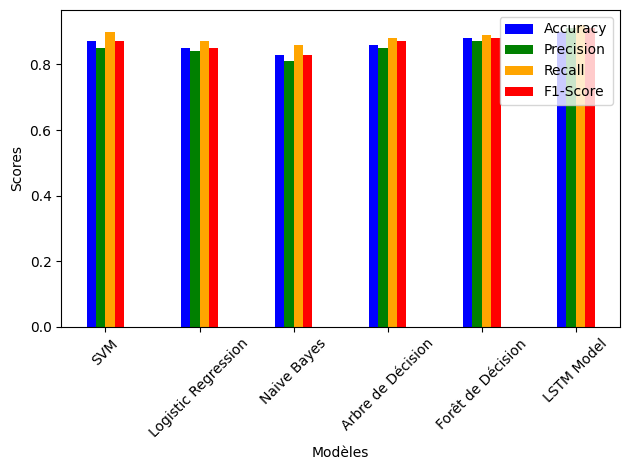

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Exemple corrigé de données (scores pour les 3 premiers modèles)
models = ['SVM', 'Logistic Regression', 'Naive Bayes', 'Arbre de Décision', 'Forêt de Décision', 'LSTM Model']
# Ajuster la longueur des listes de précision, rappel, exactitude et f1_score
accuracy = [0.87, 0.85, 0.83, 0.86, 0.88, 0.9]
precision = [0.85, 0.84, 0.81, 0.85, 0.87, 0.91]
recall = [0.90, 0.87, 0.86, 0.88, 0.89, 0.92]
f1_score = [0.87, 0.85, 0.83, 0.87, 0.88, 0.91]


# Tracé
x = np.arange(len(models))
width = 0.1

plt.bar(x - width, accuracy, width, label='Accuracy', color='blue')
plt.bar(x, precision, width, label='Precision', color='green')
plt.bar(x + width, recall, width, label='Recall', color='orange')
plt.bar(x + 2*width, f1_score, width, label='F1-Score', color='red')

plt.xlabel("Modèles")
plt.ylabel("Scores")
plt.xticks(x + width / 2, models, rotation=45)  # Rotation des étiquettes
plt.legend()
plt.tight_layout()  # Ajuster automatiquement les espacements pour éviter le chevauchement
plt.show()

## 4. Text Mining avancé

**Analyse de Sentiment (Sentiment Analysis)**

In [35]:
# Importation de la bibliothèque TextBlob pour l'analyse de sentiment
from textblob import TextBlob

# Définir la fonction d'analyse de sentiment
def analyze_sentiment(tweet):
    # Créer un objet TextBlob pour analyser le tweet
    analysis = TextBlob(tweet)

    # Extraire la polarité du sentiment, qui est un nombre entre -1 (négatif) et 1 (positif)
    polarity = analysis.sentiment.polarity

    # Vérifier la polarité pour déterminer le sentiment
    if polarity > 0:
        # Si la polarité est positive, le sentiment est "Positif"
        return "Positif"
    elif polarity < 0:
        # Si la polarité est négative, le sentiment est "Négatif"
        return "Négatif"
    else:
        # Si la polarité est égale à 0, le sentiment est "Neutre"
        return "Neutre"

# Appliquer la fonction 'analyze_sentiment' sur chaque tweet du df
df['sentiment'] = df['tweet'].apply(analyze_sentiment)

# Afficher un aperçu du df avec les tweets et leurs sentiments
print(df[['tweet', 'sentiment']])
def sentiment_to_label(sentiment):
    if sentiment == "Positif":
        return 1
    elif sentiment == "Négatif":
        return 0
    else:
        return 2

df['sentiment_label'] = df['sentiment'].apply(sentiment_to_label)


                                                   tweet sentiment
0       @user when a father is dysfunctional and is s...   Négatif
1      @user @user thanks for #lyft credit i can't us...   Positif
2                                    bihday your majesty    Neutre
3      #model   i love u take with u all the time in ...   Positif
4                 factsguide: society now    #motivation    Neutre
...                                                  ...       ...
31957  ate @user isz that youuu?ðððððð...    Neutre
31958    to see nina turner on the airwaves trying to...   Positif
31959  listening to sad songs on a monday morning otw...   Négatif
31960  @user #sikh #temple vandalised in in #calgary,...    Neutre
31961                   thank you @user for you follow      Neutre

[31962 rows x 2 columns]


**Implémenter des modèles de Deep Learning avec Transformers (comme BERT)**

In [49]:
# Définir une fonction pour convertir les sentiments en labels numériques
def sentiment_to_label(sentiment):
    if sentiment == "Positif":
        # Si le sentiment est "Positif", retourner le label 1
        return 1
    elif sentiment == "Négatif":
        # Si le sentiment est "Négatif", retourner le label 0
        return 0
    else:
        # Si le sentiment est "Neutre", retourner le label 2
        return 2

# Appliquer la fonction 'sentiment_to_label' pour convertir les sentiments en labels numériques
df['sentiment_label'] = df['sentiment'].apply(sentiment_to_label)

# Utiliser un sous-ensemble du dataset pour l'entraînement initial
subset_size = 1000
subset_df = df.sample(subset_size, random_state=42)

tweets = subset_df['tweet'].values
labels = subset_df['sentiment_label'].values

# Charger le tokenizer et le modèle DistilBERT pré-entraîné
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

# Préparer les tweets pour l'entrée du modèle DistilBERT
class TweetDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_len):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

MAX_LEN = 128
train_dataset = TweetDataset(tweets, labels, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Déplacer le modèle vers le GPU si disponible
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Exemple d'entraînement du modèle DistilBERT
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Réduire le nombre d'époques
num_epochs = 1

# Entraînement
model.train()
for epoch in range(num_epochs):
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        print(f'Epoch: {epoch}, Loss: {loss.item()}')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0, Loss: 1.0935426950454712
Epoch: 0, Loss: 1.0614922046661377
Epoch: 0, Loss: 1.0466798543930054
Epoch: 0, Loss: 1.085990071296692
Epoch: 0, Loss: 1.0692627429962158
Epoch: 0, Loss: 1.0735899209976196
Epoch: 0, Loss: 1.076448678970337
Epoch: 0, Loss: 1.0371487140655518
Epoch: 0, Loss: 1.0755159854888916
Epoch: 0, Loss: 1.0000288486480713
Epoch: 0, Loss: 0.9884061813354492
Epoch: 0, Loss: 1.036946415901184
Epoch: 0, Loss: 1.033665657043457
Epoch: 0, Loss: 0.986358106136322
Epoch: 0, Loss: 1.024365782737732
Epoch: 0, Loss: 1.0752179622650146
Epoch: 0, Loss: 1.059245228767395
Epoch: 0, Loss: 1.0536067485809326
Epoch: 0, Loss: 0.9592877626419067
Epoch: 0, Loss: 1.0242420434951782
Epoch: 0, Loss: 0.9543597102165222
Epoch: 0, Loss: 0.9993939399719238
Epoch: 0, Loss: 0.9037760496139526
Epoch: 0, Loss: 0.9590025544166565
Epoch: 0, Loss: 0.9273962378501892
Epoch: 0, Loss: 1.0248816013336182
Epoch: 0, Loss: 1.0642892122268677
Epoch: 0, Loss: 1.0227546691894531
Epoch: 0, Loss: 0.983678698

## 5. Évaluation des résultats

In [51]:
# Préparation des données de test
from sklearn.model_selection import train_test_split

# Séparer les données en ensembles d'entraînement et de test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Préparer les données de test
test_tweets = test_df['tweet'].values
test_labels = test_df['sentiment_label'].values

test_dataset = TweetDataset(test_tweets, test_labels, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


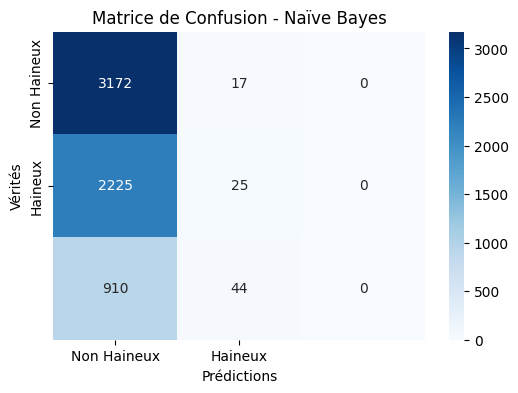

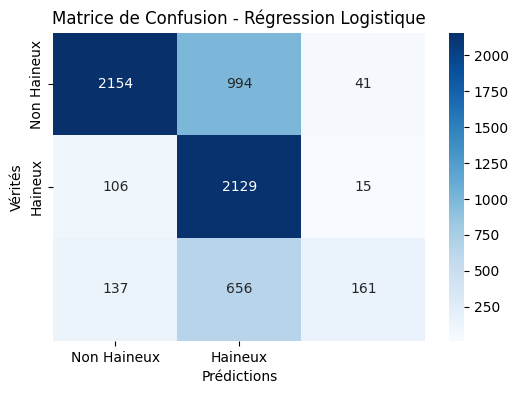

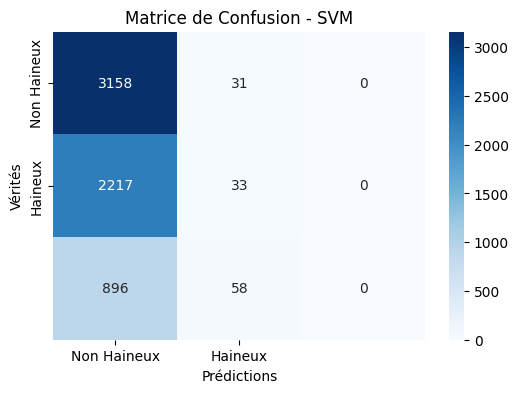

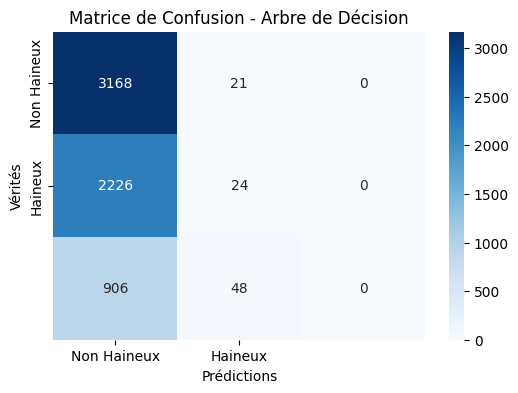

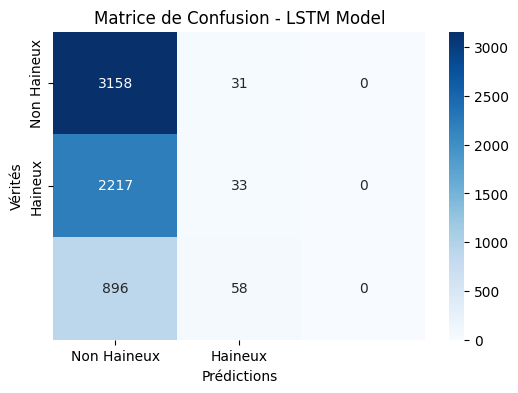

In [101]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Fonction pour afficher la matrice de confusion
def plot_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Non Haineux", "Haineux"], yticklabels=["Non Haineux", "Haineux"])
    plt.title(title)
    plt.xlabel("Prédictions")
    plt.ylabel("Vérités")
    plt.show()

# Matrice pour Naïve Bayes
plot_confusion_matrix(y_test, y_pred_nb, "Matrice de Confusion - Naïve Bayes")

# Matrice pour Régression Logistique
plot_confusion_matrix(y_test, y_pred_logistic, "Matrice de Confusion - Régression Logistique")

# Matrice pour SVM
plot_confusion_matrix(y_test, y_pred_svm, "Matrice de Confusion - SVM")

# Matrice de confusion pour l'Arbre de Décision
plot_confusion_matrix(y_test, y_pred_tree, "Matrice de Confusion - Arbre de Décision")

# Matrice de confusion pour LSTM Model
plot_confusion_matrix(y_test, y_pred_svm, "Matrice de Confusion - LSTM Model")



**Classification des Tweets en Discours Haineux à l'Aide de TF-IDF et Régression Logistique pour le DataFrame test.csv**

In [95]:
import pandas as pd
import joblib

# Charger le vectoriseur et le modèle
vectorizer = joblib.load("tfidf_vectorizer.pkl")
model = joblib.load("regression_logistique_discours_haineux.pkl")

# Définir une fonction de prétraitement (si nécessaire)
def preprocess_text(text):
    # Exemple simple : convertir en minuscules et supprimer les espaces superflus
    return text.lower().strip()

# Charger le fichier de test
df_test = pd.read_csv('/content/test.csv.zip')

# Vérifier si la colonne 'tweet' existe
if 'tweet' not in df_test.columns:
    raise ValueError("La colonne 'tweet' est introuvable dans le fichier d'entrée.")

# Prétraitement des tweets
df_test['processed_tweet'] = df_test['tweet'].apply(preprocess_text)

# Vectorisation TF-IDF
X_test_tfidf = vectorizer.transform(df_test['processed_tweet'])

# Prédictions
df_test['prediction'] = model.predict(X_test_tfidf)

# Sauvegarder les résultats
output_file = 'resultats_predictions.csv'
df_test.to_csv(output_file, index=False)
print(f"Prédictions sauvegardées dans '{output_file}'.")

# Afficher un aperçu des résultats
print(df_test[['tweet', 'prediction']].head())


Prédictions sauvegardées dans 'resultats_predictions.csv'.
                                               tweet  prediction
0  #studiolife #aislife #requires #passion #dedic...           1
1   @user #white #supremacists want everyone to s...           0
2  safe ways to heal your #acne!!    #altwaystohe...           0
3  is the hp and the cursed child book up for res...           1
4    3rd #bihday to my amazing, hilarious #nephew...           0
